In [ ]:
import numpy as np
import json
import bz2
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import psutil
# import csv
import pickle
# import pandas as pd
from pymatgen.core import Structure
import math
pd.options.display.max_colwidth = 100
# sns.set_theme(style = 'ticks')

# st = sns.axes_style("ticks")
# # sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (8,8)})
# sns.set(style = st,palette = sns.color_palette("muted"))
# sns.set(style = st,palette = sns.color_palette("tab10"))

# # np.set_printoptions(threshold=np.inf)
# #sns.set(color_codes = True)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Computer Modern Roman"]})

In [ ]:
import seaborn as sns
from tqdm import tqdm

import psutil
# import csv
import pickle
# import pandas as pd
from pymatgen.core import Structure
import math
pd.options.display.max_colwidth = 100
# sns.set_theme(style = 'ticks')

# st = sns.axes_style("ticks")
# # sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (8,8)})
# sns.set(style = st,palette = sns.color_palette("muted"))
# sns.set(style = st,palette = sns.color_palette("tab10"))

# # np.set_printoptions(threshold=np.inf)
   
# #sns.set(color_codes = True)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Computer Modern Roman"]})

In [ ]:
# def save_arr_to_csv(arr, path):
#     with open(path, mode = 'w', newline = '') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(arr)

# def read_from_csv(path):
#     with open(path, mode = 'r') as csvfile:
#         reader = csv.reader(csvfile)
#         arr = [row for row in reader]
#     return arr

#### Custom Methods

In [ ]:
def separate_forces(var_forces):
    arr = []
    for index, force_arr in enumerate(var_forces):
        if len(force_arr) > 1:
            # print(force_arr)
            # print(len(force_arr))
            for i in range(len(force_arr)):
                # print(force_arr[i])
                arr.append(force_arr[i])
        else:
            arr.append(force_arr)
    return arr

def get_coordinate(array, axis = 'x'):

    switcher = {
        "x": int(0),
        "y": int(1),
        "z": int(2),
    }

    switch = switcher.get(axis, "nothing")
    coordinate_arr = [arr[switch] for arr in tqdm(array)] 
    print(coordinate_arr)
    return coordinate_arr


def magnitude_vec(vector):
    print("Vector: {}".format(vector)) 
    # print(sum(pow(element, 2) for element in vector))
    # print([element for element in vector])
    print(math.sqrt(sum(np.power(element, 2) for element in vector)))
    return math.sqrt(sum(np.power(element, 2) for element in vector))

    # return math.sqrt(sum(np.power(element, 2) for element in vector))

def abs_forces_per_run(var_forces):
    arr = []
    for index, force_arr in enumerate(var_forces):
        if len(force_arr) > 1:
            print(force_arr)
            sum_arr = 0
            for i in range(len(force_arr)):
                print(force_arr[i])
                sum_arr += magnitude_vec(force_arr[i])
            arr.append(sum_arr)
        else:
            arr.append(magnitude_vec(force_arr[0]))
    return arr


def import_df(path):
    df = pd.read_pickle("{}".format(path))
    return df


def add_cum_count(df):
    cum_series = df.groupby('run').cumcount()
    cum_series = cum_series.astype(str)
    df['run'] = df['run'] + "_" + cum_series


In [ ]:
def get_df(directory, overwrite = False):
    if overwrite == True:
        print("Number of files in directory: {}".format(len(os.listdir(directory))))
        files = os.listdir(directory)
        print(files)

        df_data = pd.DataFrame(columns=['run', 'energy', 'forces', 'stress_xx', 'stress_xy', 'stress_xz', 'stress_yx', 'stress_yy', 'stress_yz', 'stress_zx', 'stress_zy', 'stress_zz'])

        for file_name in files:
            print("Current file selected: {}".format(file_name))
            print('RAM memory % used:', psutil.virtual_memory()[2])
            # Getting usage of virtual_memory in GB ( 4th field)
            print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
            with bz2.BZ2File("{}/{}".format(directory,file_name)) as file:
                for line in file:
                    line = line.decode().strip()
                    if line in {"[", "]"}:
                        continue
                    if line.endswith(" "):
                        line = line[:-1]
                    entity =json.loads(line)
                    for run in entity.keys():
                        for item in entity[run]:
                            # print(item)
                            struc = Structure.from_dict(item['structure'])
                            forces = item['forces']
                    
                            stress = item['stress']
                            energy = item['energy']
                            
                            # if energy > 0:
                            #     print("There is a positive energy entry: {}".format(energy))
                            
                            data_run = pd.DataFrame({'run': run,
                                                        "structure": [struc],
                                                        "energy": energy, 
                                                        "forces": [forces], 
                                                        'stress_xx': [stress[0][0]], 'stress_xy': [stress[0][1]], 'stress_xz':[stress[0][2]], 
                                                        'stress_yx': [stress[1][0]], 'stress_yy': [stress[1][1]], 'stress_yz': [stress[1][2]], 
                                                        'stress_zx': [stress[2][0]], 'stress_zy': [stress[2][1]], 'stress_zz': [stress[2][2]]})

                            data_run = pd.DataFrame(data_run)
                            df_data = pd.concat([df_data, data_run])

        df_data.reset_index(inplace = True, drop = True)

        add_cum_count(df_data)
        
        df_data.memory_usage()
        df_data.to_pickle("df_data.pkl")

    elif overwrite == False:
       df_data = import_df('df_data.pkl')

    return df_data

def create_arr(directory):

    print("Number of files in directory: {}".format(len(os.listdir(directory))))
    files = os.listdir(directory)
    print(files)

    dict_id = {}
    # df_id = pd.DataFrame(columns = ["id", "run"])

    struc_arr = []
    stress_arr = []
    energy_arr = []
    forces_arr = []
    index = 0

    for file_name in tqdm(files):
        print("Current file selected: {}".format(file_name))
        
        with bz2.BZ2File("{}/{}".format(directory,file_name)) as file:
            for line in tqdm(file):
                line = line.decode().strip()
                if line in {"[", "]"}:
                    continue
                if line.endswith(" "):
                    line = line[:-1]
                entity =json.loads(line)
                for run in entity.keys():
                    for item in entity[run]:
                        # print(len(entity[run]))
                        # struc = Structure.from_dict(item['structure'])
                        struc = item['structure']
                        forces = item['forces']
                        stress = item['stress']
                        energy = item['energy']
                        
                        dict_id[index] = run

                        stress_arr.append(stress)
                        forces_arr.append(forces)
                        energy_arr.append(energy)
                        struc_arr.append(struc)
                        
                        with open('log.txt', 'a') as f:
                            f.write("{}-{}: Energy: {}, Forces: {}, Stress: {} + \n".format(run, index, energy, forces, stress))
                        index += 1

    return struc_arr, energy_arr, stress_arr, forces_arr, dict_id

In [ ]:
struc_arr, energy_arr, stress_arr, forces_arr, dict_id = create_arr("geo_opt")

#### Obtain Structure Information

In [ ]:
def get_struc_data(directory):
    #! CAN PROBABLY BE DELETED (SEE METHOD CREATE ARR)

    print("Number of files in directory: {}".format(len(os.listdir(directory))))
    files = os.listdir(directory)
    print(files)

    # dict_id = {}
    # df_id = pd.DataFrame(columns = ["id", "run"])
    struc = []

    struc_arr = np.empty((np.shape(energy_arr)[0],1), dtype = object)

    # print(struc_arr)

    i = 0
    for file_name in tqdm(files):
        print("Current file selected: {}".format(file_name))
        with bz2.BZ2File("{}/{}".format(directory,file_name)) as file:
            for line in tqdm(file):
                line = line.decode().strip()
                if line in {"[", "]"}:
                    continue
                if line.endswith(" "):
                    line = line[:-1]
                entity =json.loads(line)
                for run in entity.keys():
                    # i  = 0
                    for item in entity[run]:
                        # print(len(entity[run]))
                        # struc = Structure.from_dict(item['structure'])
                        # print(run['structure'])
                        # print(item['structure'])
                        st = item['structure']
                        # struc_arr[0] = st

                        struc_arr[i] = st

                        i += 1
                        
                        # struc_array = np.append(struc_array, [st], axis=0)
                        # st = item['structure'][i]

                        # struc.append(st)
                        

    return struc_arr

In [ ]:
struc_arr = get_struc_data("geo_opt")

In [ ]:
print(type(struc_arr))
print(struc_arr.dtype)
print(type(struc_arr)[0])
print(np.shape(struc_arr))
test_str = Structure.from_dict(struc_arr[0])
print(test_str)

#### Split val, test and train data

In [ ]:
# TODO Finish this section
from sklearn.model_selection import train_test_split
train, test_val = train_test_split(data, test_size=0.1, train_size=0.9, random_state=1, shuffle=True)
test, val = train_test_split(test_val, test_size=0.5, train_size=0.5, random_state=2, shuffle=True)

#### Save and load data arrays

In [ ]:
def save_arr_json(arr, path):
    with open(path, mode = 'w') as line:
        json.dump(arr, line)

def read_arr_json(path):
    with open(path, mode = 'r') as line:
        arr = json.load(line)
    return np.array(arr)

def save_id_dict(dict, path):
    # BEWARE JSON turns keys into strings and not int
    with open(path, 'w') as line:
        json.dump(dict, line)

def load_id_dict(path):
    with open(path, 'r') as line:
        arr = json.load(line)
    return arr

In [ ]:
np.save("struc_arr_complete", struc_arr)
# save_arr_json(struc_arr, "struc_arr.txt")
save_arr_json(forces_arr, "forces_arr.txt")
save_arr_json(stress_arr, "stress_arr.txt")
save_arr_json(energy_arr, "energy_arr.txt")
save_id_dict(dict_id, "id_run.txt")

In [ ]:
# struc_arr = read_arr_json("struc_arr.txt")
struc_arr_d = np.load("struc_arr_complete.npy", allow_pickle=True)
forces_arr = read_arr_json("forces_arr.txt")
energy_arr = read_arr_json("energy_arr.txt")
stress_arr = read_arr_json("stress_arr.txt")
id_run = load_id_dict("id_run.txt")

print(np.shape(struc_arr_d))
print(np.shape(forces_arr))
print(np.shape(energy_arr))
print(np.shape(stress_arr))

In [ ]:
nr_atoms_per_run = [np.shape(x)[0] for x in tqdm(forces_arr[:])]

#### Reformat kbar to Gpa for stress

In [ ]:
# REFORMAT THE STRUCTURE ARRAY TO GPA AND SAVE IT
# stress_arr_ref = np.array(-0.1*stress_arr/160.21766208) #kbar to GPa for m3gnet
stress_arr_ref = np.array(-0.1*stress_arr) #convert from kbar to GPa for m3gnet
np.savetxt('stress_arr_gpa.txt', stress_arr_ref.reshape(-1, stress_arr_ref.shape[-1])) #reshape into a 2D array to save it

#### Load the GPa stress array

In [ ]:
stress_arr_gpa = np.loadtxt('stress_arr_gpa.txt').reshape(np.shape(energy_arr)[0], 3, 3) #reshape the imported 2d array into the 3d array
print(np.shape(stress_arr_gpa))

#### Reformat Key dictionary

In [ ]:
id_reformated = {}
for key, val in id_run.items():
    # print(key, val)
    try:
        id_reformated[val].append(key)
    except:
        id_reformated[val] = [key]

In [ ]:
save_id_dict(id_reformated, "id_run_reformat.txt")

In [ ]:
print(len(id_run.keys()))
print(len(id_reformated.keys()))

In [ ]:
id_reformated = load_id_dict("id_run_reformat.txt")

### Energies

In [ ]:
def histogram_1d_energy(arr, name, xrange = [-160,100]):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(arr, bins = 1000)
    ax.set_xlabel("{}".format("Energy"))
    ax.set_xlim(xrange)
    ax.set_ylabel("Counts")
    plt.tight_layout()
    plt.savefig("Figures/{}.pdf".format(name))

#### Outlier Removal energy

In [ ]:
energy_arr = np.array(energy_arr)

id_outlier_energy = np.where((energy_arr < 0.0) & (energy_arr > -150))[0]
id_outlier_stress = np.where((stress_arr[:,0,0] < 50) & (stress_arr[:, 0,0] > -50))[0]

print(id_outlier_energy)
print(id_outlier_stress)

outlier_id = np.intersect1d(id_outlier_energy, id_outlier_stress)

energy_arr_cut = energy_arr[id_outlier_energy]

energy_arr_cut


energy_arr_cut_complete = energy_arr[outlier_id]
stress_arr_cut_complete = stress_arr[outlier_id, 0, 0]


# print(np.shape(energy_arr))
print(np.shape(energy_arr_cut))
print(np.shape(energy_arr_cut_complete))


print(np.shape(stress_arr_cut_complete))



print(np.max(energy_arr_cut_complete))


# arr = set([id_run[x] for x in id_outlier])

#### Energy per atom histogram

In [ ]:
def find_outliers(arr, larger_than, smaller_than):

    if smaller_than == None and larger_than != None:
        id_outliers = np.where(arr > larger_than)[0]
        # id_outliers_top = np.where(arr < smaller_than)[0]
        # id_outliers = np.concatenate((id_outliers_bottom, id_outliers_top))
    elif larger_than and smaller_than != None:
        id_outliers_bottom = np.where(arr > larger_than)[0]
        id_outliers_top = np.where(arr < smaller_than)[0]
        id_outliers = np.concatenate((id_outliers_bottom, id_outliers_top))

    outlier_energy_names = set([id_run["{}".format(x)] for x in tqdm(id_outliers)])

    return outlier_energy_names, id_outliers

def remove_outliers(arr, cut_top, cut_bot):
    cropped_arr = [x for x in arr if x <= cut_top and  x >= cut_bot]
    id_outliers_bottom = np.where(arr > cut_bot)[0]
    id_outliers_top = np.where(arr < cut_top)[0]
    id_outliers = np.intersect1d(id_outliers_bottom, id_outliers_top)
    return cropped_arr, id_outliers

In [ ]:
energy_per_atoms = np.divide(energy_arr, nr_atoms_per_run)
energy_per_atom_cropped, id_out_energy =remove_outliers(energy_per_atoms, cut_top = 0, cut_bot = -12.5)

In [ ]:
print(np.shape(energy_per_atom_cropped))
print(np.shape(id_out_energy))
print(np.shape(energy_per_atoms))

In [ ]:
histogram_1d_energy(energy_per_atom_cropped, "energy_per_atom", xrange = [-20,0])

### Forces

#### Create concatenated forces array

In [ ]:
def get_concat_force(arr):
    forces_arr_concat = [np.array(x) for x in tqdm(arr)]
    print("Shape force array: {}".format(np.shape(forces_arr_concat)))
    forces_arr_concat = np.concatenate(forces_arr_concat, axis = 0)
    print("Concat force array: {}".format(np.shape(forces_arr_concat)))
    return forces_arr_concat

In [ ]:
force_arr_concat = get_concat_force(forces_arr)

In [ ]:
np.savetxt('force_arr_concat.txt', force_arr_concat, delimiter = '')
# Load the concatenated force arr from the txt file
force_arr_concat = np.genfromtxt("force_arr_concat.txt")

In [ ]:
#! Can be removed
# forces_arr_concat = [np.array(x) for x in forces_arr]
# print(np.shape(forces_arr_concat))
# forces_arr_concat = np.concatenate(forces_arr_concat, axis = 0)
# print(np.shape(forces_arr_concat))
# # Save the concatenate force arr
# np.savetxt('force_arr_concat.txt', forces_arr_concat, delimiter = '')
# # Load the concatenated force arr from the txt file
# force_arr_concat = np.genfromtxt("force_arr_concat.txt")

#### Histogram Forces

In [303]:
def histogram_1d_forces(arr, component, xrange = [-160,100], ylim = None):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(arr, bins = 500)
    ax.set_xlabel("Force {}".format(component))
    ax.set_xlim(xrange)
    ax.set_ylabel("Counts")
    plt.tight_layout()
    if ylim != None:
        ax.set_ylim([0, ylim])
        plt.savefig("Figures/forces_{}_cut.pdf".format(component))
    else:
        plt.savefig("Figures/forces_{}.pdf".format(component))

def force_ravelled(arr):
    # Flattens the 2nd dimension of the force array
    ravelled_force = []
    for id in tqdm(range(np.shape(arr)[0])):
        forces_ravelled = np.ravel(arr[id])
        # print(np.shape(forces_ravelled))
        # print(forces_ravelled )
        ravelled_force.append(forces_ravelled)
        # ravelled_force = np.append(ravelled_force, forces_ravelled, axis = 1)

    return np.array(ravelled_force, dtype = object)


In [ ]:
force_ravell = force_ravelled(forces_arr)

In [293]:
def remove_outliers_forces(arr, cut_top, cut_bot):
    # cropped_arr = [x for x in arr if x <= cut_top and  x >= cut_bot]
    # cropped_arr = np.where(arr.all() > cut_bot)
    # np.where(arr > cut_bot, arr)
    # print(np.any(arr > cut_bot, axis = 1))
    keep_entry = []
    
    for i in tqdm(range(np.shape(arr)[0])):
        # bool_bot =  np.all((arr[i] >= cut_bot))
        # bool_top = np.all(((arr[i] <= cut_top)))

        # print(arr[i])
        bool = np.all((arr[i] >= cut_bot) & (arr[i] <= cut_top))
        keep_entry.append(bool)
            # print(arr[i])
    # id_keep = np.where(keep_entry==True)
    # print(id_keep)
    # print(len(keep_entry))
    print(len(keep_entry))
    id_keep = np.where(keep_entry)[0]
    print(np.shape(id_keep))
    arr_cut = arr[np.where(keep_entry)]
    # print("Max: {}, Min: {}".format(np.max(arr_cut), np.min(arr_cut)))
    return arr_cut, id_keep
    # np.where(np.any(arr > cut_bot), axis = 1)
    # cropped_arr = np.any(np.where(arr > cut_bot))
    # print(np.max(cropped_arr))


    # print("Max: {}, Min: {}".format(np.max(cropped_arr), np,min(cropped_arr)))
    # id_outliers_bottom = np.where(arr > cut_bot)[0]
    # id_outliers_top = np.where(arr < cut_top)[0]
    # id_outliers = np.intersect1d(id_outliers_bottom, id_outliers_top)
    # return cropped_arr, id_outliers

In [322]:
force_ravelled_cropped, id_force_outliers = remove_outliers_forces(force_ravell, cut_top = 20, cut_bot=-20)
print(np.shape(force_ravelled_cropped))
print(np.shape(id_force_outliers))

100%|██████████| 5889788/5889788 [00:28<00:00, 208027.88it/s]


5889788
(5887173,)
(5887173,)
(5887173,)


#### Merge the energy and force id

In [323]:
id_outl_rm = np.intersect1d(id_force_outliers, id_out_energy)
print(len(id_out_energy))
print(len(id_outl_rm))

5885754
5884314


Crop the forces_arr using the id from the outlier removal

In [324]:
force_arr_cropped = forces_arr[id_outl_rm]
print(np.shape(force_arr_cropped))

(5884314,)


#### Get the concat forces array for the outlier removed force array

In [325]:
force_arr_cropped_concat = get_concat_force(force_arr_cropped)
print(np.max(force_arr_cropped_concat))
print(np.min(force_arr_cropped_concat))

100%|██████████| 5884314/5884314 [00:32<00:00, 180101.92it/s]
/Users/fabianjaeger/miniconda/envs/master_thesis/lib/python3.11/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Shape force array: (5884314,)
Concat force array: (64806691, 3)
19.97788279
-19.98967072


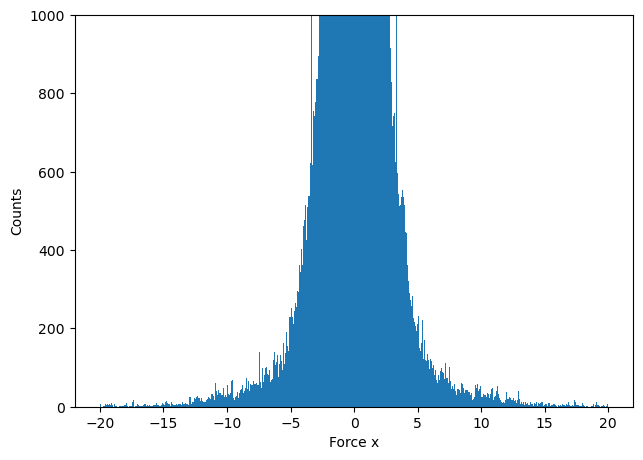

In [326]:
forces_arr_x = force_arr_cropped_concat[:,0]
histogram_1d_forces(forces_arr_x, component = "x", xrange = None, ylim = 1e3)

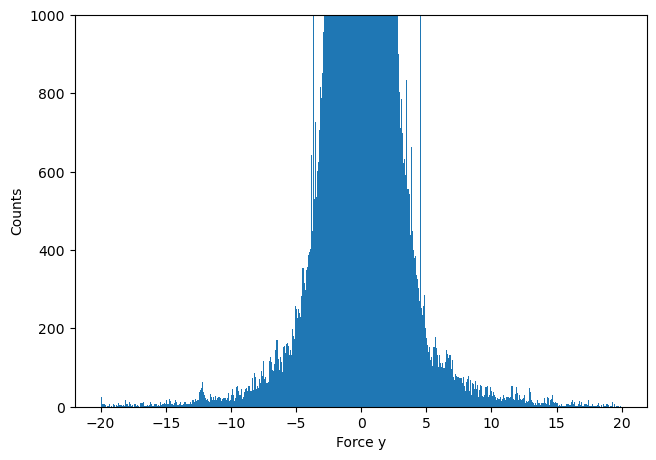

In [327]:
forces_arr_y = force_arr_cropped_concat[:,1]
histogram_1d_forces(forces_arr_y, component = "y", xrange = None, ylim = 1e3)

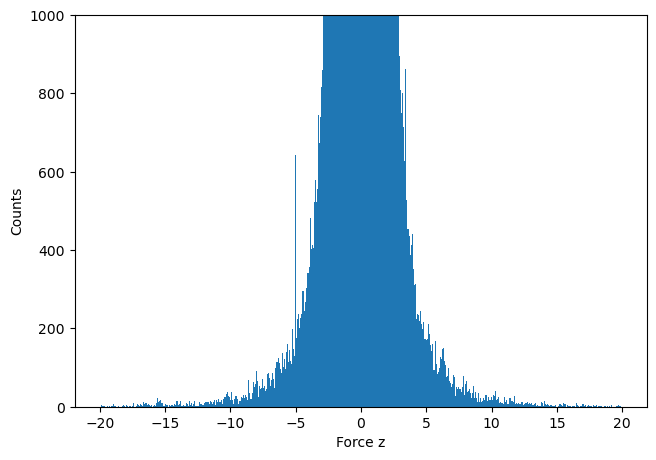

In [328]:
forces_arr_z = force_arr_cropped_concat[:,2]
histogram_1d_forces(forces_arr_z, component = "z", xrange = None, ylim = 1e3)

### Stress

In [345]:
def stress_cut(stress_arr, component, cutoff):
    stress_comp = stress_arr[:, component[0], component[1]]
    stress_comp_cut = stress_comp[np.where(abs(stress_comp) < cutoff)]
    print("Min: {}, Max: {}".format(np.min(stress_comp_cut), np.max(stress_comp_cut)))
    return stress_comp_cut

def stress_cut_hist(stress_arr, component, cutoff, nr_bin, y_lim):
    stress_comp = stress_arr[:, component[0], component[1]]

    switcher = {
        0: "x",
        1: "y",
        2: "z"
    }

    axis_1 = switcher.get(component[0], "nothing")
    axis_2 = switcher.get(component[1], "nothing")

    print('Chosen component: {}'.format(axis_1 + axis_2))
    
    stress_arr_cut = stress_cut(stress_arr, component, cutoff)

    plt.xlabel("Stress_{}".format(axis_1 + axis_2))
    
    plt.hist(stress_arr_cut, bins = nr_bin)
    plt.tight_layout()
    if y_lim!= None:
        plt.ylim([0, y_lim])
        plt.savefig("Figures/stress_{}{}_cut.pdf".format(axis_1, axis_2))
    else:
        plt.savefig("Figures/stress_{}{}.pdf".format(axis_1, axis_2))


def stress_cut_hist_comb(stress_arr, cutoff, nr_bin, ylim):
    stress_xx = stress_arr[:, 0, 0]
    stress_xy = stress_arr[:, 0, 1]
    stress_yx = stress_arr[:, 1, 0]
    stress_yy = stress_arr[:, 1, 1]


    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    axs[0, 0].hist(stress_xx, bins = nr_bin)
    # axs[0, 0].set_title('Axis [0,0]')
    axs[0, 1].hist(stress_xy, bins = nr_bin)
    # axs[0, 1].set_title('Axis [0,1]')
    axs[1, 0].hist(stress_yx, bins = nr_bin)
    # axs[1, 0].set_title('Axis [1,0]')
    axs[1, 1].hist(stress_yy, bins = nr_bin)

    plt.setp(axs, xlim = [-cutoff, cutoff], ylim=[0, ylim])
    fig.savefig("Figures/stress_comb.pdf")

    # axs[0, 0].set_ylim([0, ylim])
    # axs[0, 1].set_ylim
    # axs[1, 1].set_title('Axis [1,1]')

#### Remove outliers from force and energy

In [342]:
stress_arr_cut = stress_arr[id_outl_rm]
print(np.shape(stress_arr_cut))

(5884314, 3, 3)


#### Histograms

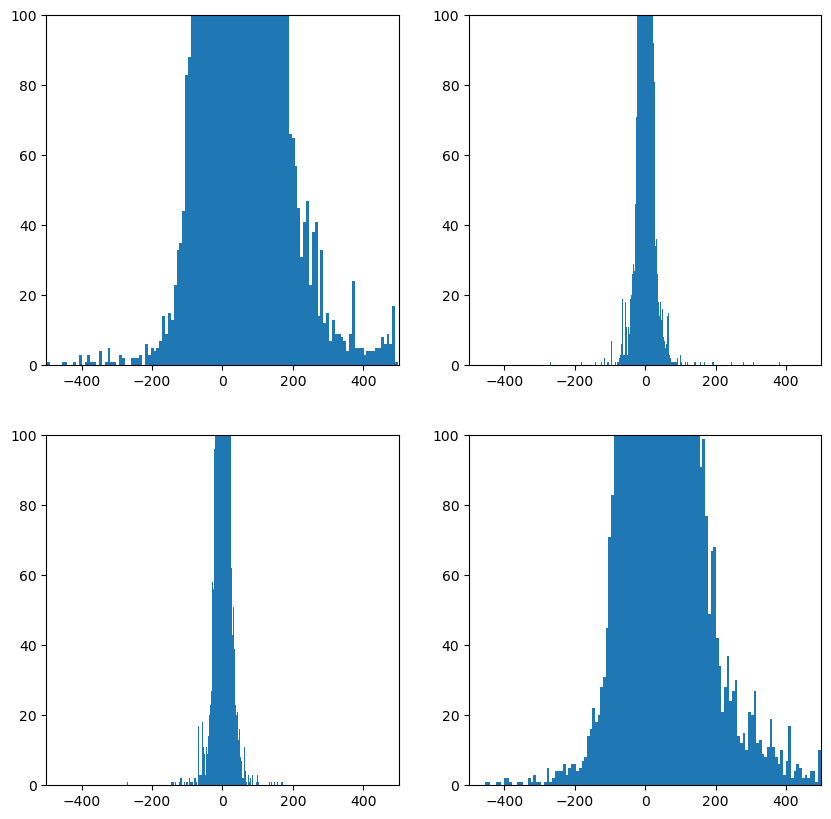

In [346]:
stress_cut_hist_comb(stress_arr_cut, cutoff = 500, nr_bin=1000, ylim = 1e2)

### Ravel and find stress outliers

In [347]:
def stress_ravelled(arr):
    # Flattens the 2nd dimension of the force array
    ravelled_stress = []
    for id in tqdm(range(np.shape(arr)[0])):
        stress_ravelled = np.ravel(arr[id])
        # print(np.shape(forces_ravelled))
        # print(forces_ravelled )
        ravelled_stress.append(stress_ravelled)
        # ravelled_force = np.append(ravelled_force, forces_ravelled, axis = 1)

    return np.array(ravelled_stress, dtype = object)

In [355]:
stress_ravelled_arr = stress_ravelled(stress_arr)

100%|██████████| 5889788/5889788 [00:02<00:00, 2009157.78it/s]


In [356]:
stress_ravelled_arr_cut, id_stress_outliers = remove_outliers_forces(stress_ravelled_arr, cut_top = 300, cut_bot = -300)

100%|██████████| 5889788/5889788 [00:26<00:00, 223749.17it/s]


5889788
(5887147,)


In [357]:
id_outl_rm = np.intersect1d(id_stress_outliers, id_outl_rm)

In [358]:
stress_arr_cut_complete = stress_arr[id_outl_rm]
print(np.shape(stress_arr_cut_complete))

(5877821, 3, 3)


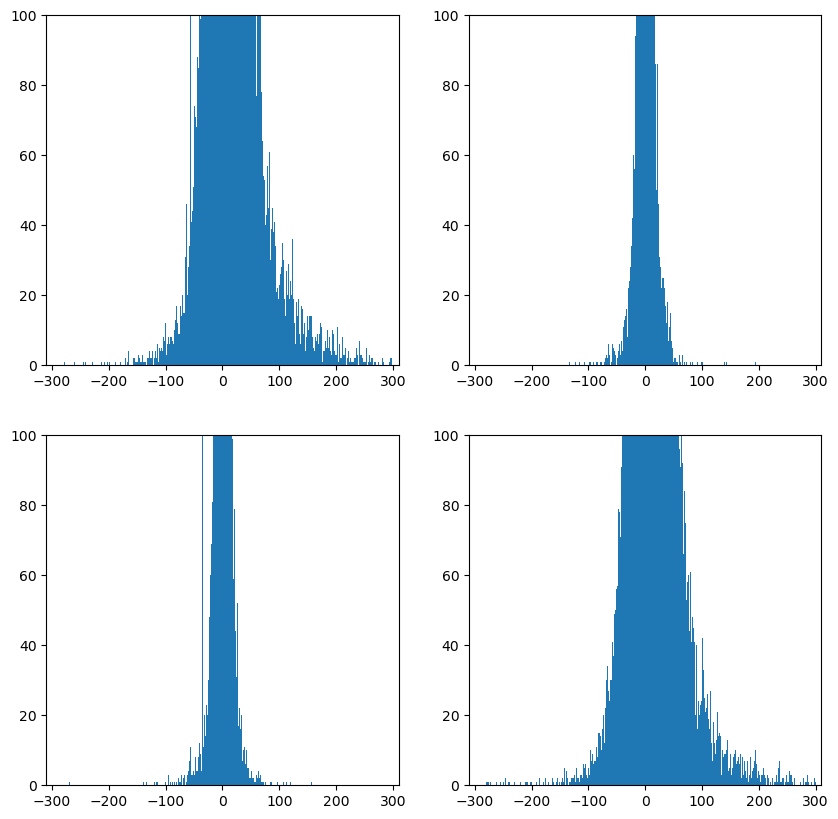

In [360]:
# HISTOGRAM WITH OUTLIER REMOVED STRESSES
stress_cut_hist_comb(stress_arr_cut_complete, cutoff = 310, nr_bin=1000, ylim = 1e2)

### Outliers

#### Find id and name of all outliers

In [381]:
outlier_ids = np.setdiff1d(np.arange(start = 0, stop = np.shape(energy_arr)[0]), id_outl_rm)
print("Number of outliers found: {}".format(np.shape(outlier_ids)))
outlier_names = set([id_run["{}".format(x)] for x in tqdm(outlier_ids)])

Number of outliers found: (11967,)


100%|██████████| 11967/11967 [00:00<00:00, 146006.92it/s]


In [382]:
with open("outliers_names.txt", "w") as f:
    for s in outlier_names:
        f.write(str(s) +"\n")

with open("outliers_id.txt", "w") as f:
    for s in outlier_ids:
        f.write(str(s) +"\n")

#### Find positive energy outliers

In [ ]:
outlier_energy_pos, id_energy_outliers_pos = find_outliers(energy_arr, larger_than= 0, smaller_than = None)

In [ ]:
print(np.shape(id_energy_outliers_pos))
print(np.min(energy_arr[id_energy_outliers_pos]))

In [ ]:
with open("energy_outliers_pos.txt", "w") as f:
    for s in outlier_energy_pos:
        f.write(str(s) +"\n")

#### Find outliers

In [ ]:
energy_arr = np.array(energy_arr)

In [ ]:
id_outliers_bottom = np.where(energy_arr > 0.0)[0]
id_outliers_top = np.where(energy_arr < -150)[0]


energy_outliers = np.concatenate((id_outliers_bottom, id_outliers_top))

print(id_outliers_bottom)
print(id_outliers_top)
print(energy_outliers)


print(energy_outliers[0])
energy_name = id_run["{}".format(energy_outliers[0])]


outlier_energy_names = set([id_run["{}".format(x)] for x in tqdm(energy_outliers)])
print(outlier_energy_names)

# outlier_energy_name = set([x for x in energy_outliers])


# print(energy_arr[317573])

In [ ]:
print(np.shape(outlier_energy_names)) 

In [ ]:
# set_test = [id_run["{}".format(x)] for x in tqdm(energy_outliers[0:200])]
# set_test = [x for x in tqdm(energy_outliers[:200])]
set_test = [id_run["{}".format(x)] for x in tqdm(energy_outliers)]

In [ ]:
set_test = list(set(set_test))

# Archive

### Other stuff

In [ ]:
stress_arr_cut = stress_arr[id_outlier, :, :]
print(np.shape(stress_arr_cut))

In [ ]:
np.max(energy_arr_cut)

## Unit Convention

Energy: eV
Force: eV/Angstrom
Stress: technically eV/Angstrom^2 but are something kbar from VASP

In [ ]:
def histogram2d_stress_energy(energy_arr_cut, stress_arr_cut, component, bin, stress_lim):

    stress_arr_cut_comp = stress_arr_cut[:, component[0], component[1]]

    switcher = {
        0: "x",
        1: "y",
        2: "z"
    }

    axis_1 = switcher.get(component[0], "nothing")
    axis_2 = switcher.get(component[1], "nothing")

    print('Chosen component: {}'.format(axis_1 + axis_2))
    plt.hist2d(energy_arr_cut, stress_arr_cut_comp, bins = bin)
    plt.xlabel("Energy")
    plt.ylabel("Stress_{}".format(axis_1 + axis_2))
    plt.ylim(stress_lim[0],stress_lim[1])
    plt.savefig("Figures/energy_stress_{}_hist.pdf".format(axis_1 + axis_2))

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s = 1)
    sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1, ax = ax)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

In [ ]:
np.max(stress_arr_cut_complete)

In [ ]:

g = sns.jointplot(x=energy_arr_cut_complete, y=stress_arr_cut_complete, kind="kde", color="#4CB391", bins=25)
g.ax_joint.set_ylim([-5,5]) 
# g.ax_joint.set_xscale('log')
# g.ax_joint.set_yscale('log')

In [ ]:

# # plt.set_yscale('log')
# plt.yscale('log')
# sns.jointplot(x=energy_arr_cut_complete, y=stress_arr_cut_complete, kind="hex", color="#4CB391")



In [ ]:
sns.kdeplot(x = energy_arr_cut_complete, y = stress_arr_cut_complete, level  = 2, color = 'r', linewidth = 1)

In [ ]:
sns.set_theme(style="white")

g = sns.JointGrid(x = energy_arr_cut_complete, y = stress_arr_cut_complete space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((2200, 6800), (10, 25)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

In [ ]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.set_xlim([-160,10])
ax.set_ylim([-50,50])
# Draw the scatter plot and marginals.
scatter_hist(energy_arr_cut_complete, stress_arr_cut_complete, ax, ax_histx, ax_histy)
fig.savefig("Figures/{}.pdf".format("hist2d_stress_energy"))

In [ ]:
histogram2d_stress_energy(energy_arr_cut, stress_arr_cut, component = [1,1], bin =  1000, stress_lim = [-50, 50])

In [ ]:
plt.hist2d(energy_arr_cut, stress_arr_cut[:,0,0], bins  =100)
plt.ylim([-0.1, 0.1])

In [ ]:
import seaborn as sns
sns.jointplot(x=energy_arr_cut_complete, y=stress_arr_cut_complete, kind = 'hex')
# plt.ylim[1,1]

#### Cropping Energies

In [ ]:
cropped_energies = [x for x in energy_arr if x <= 0 and  x >= -180]
cropped_energies_top = [x for x in energy_arr if x >= 100]

In [ ]:
histogram_1d_energy(cropped_energies, "energy_hist")

In [ ]:
np.shape(cropped_energies)

## Forces

#### Outlier Removal

In [ ]:
# def get_outliers():
#     cut_force_top =  1
#     cut_force_bot = -1
#     cut_energy_bot = -150
#     cut_energy_top = 0
#     cut_stress_top = 1
#     cut_stress_bot = -1

#     out_energy_id = np.where(energy_arr < cut_energy_top)
#     # out_force_id = np.where(np.logical_and(forces_arr < cut_force_top, forces_arr > cut_force_bot))[0]

#     print(out_energy_id)
#     print(energy_arr[0:10])
# get_outliers()

#### Stress Histogram

In [ ]:
stress_arr = np.array(stress_arr)

In [ ]:
stress_cut_hist(stress_arr, component = [0,1], cutoff = 50, nr_bin = 1000, y_lim = 1000)

In [ ]:
stress_cut_hist(stress_arr, component = [0,0], cutoff = 50, nr_bin = 1000, y_lim = 10000)

In [ ]:

stress_arr = np.array(stress_arr)
energy_arr =np.array(energy_arr)
# print(type(energy_arr))
print(np.shape(energy_arr))
print(np.shape(stress_arr))

stress_xx = stress_arr[:,0,0]
stress_xy = stress_arr[:,0,1]
stress_xz = stress_arr[:,0,2]
stress_yx = stress_arr[:,1,0]
stress_yy = stress_arr[:,1,1]
stress_yz = stress_arr[:,1,2]
print(np.shape(stress_xx))

# np.mean(stress_xx)
# outliers = np.where(stress_xx > 1)
# print(outliers[0])

stress_arr_cut_xx = stress_xx[np.where(abs(stress_xx) < 3)]
energy_arr_cut_stress_xx = energy_arr[np.where(abs(stress_xx) < 1)]


print(np.shape(energy_arr_cut_stress_xx))

In [ ]:
np.shape(energy_arr_cut_stress_xx)
np.shape(stress_arr_cut_xx)

# np.min(stress_arr_cut)

np.max(energy_arr_cut_stress_xx)
np.max(stress_arr_cut_xx)
np.min(stress_arr_cut_xx)

In [ ]:
plt.hist2d(energy_arr_cut_stress_xx, stress_arr_cut)

In [ ]:
# cropped_energies = [x for x in energy_arr if x <= 0 and  x >= -150]
cutoff_top = 0.25
cutoff_bottom = -0.25

cropped_forces_x = forces_arr_x[np.where(np.logical_and(forces_arr_x < cutoff_top, forces_arr_x > cutoff_bottom))]
cropped_forces_y = forces_arr_y[np.where(np.logical_and(forces_arr_y < cutoff_top, forces_arr_y > cutoff_bottom))]
cropped_forces_z = forces_arr_z[np.where(np.logical_and(forces_arr_z < cutoff_top, forces_arr_z > cutoff_bottom))]
# np.min(cropped_forces_x)

# cropped_forces_x = np.where((forces_arr_x <= cutoff_top) or (forces_arr_x >= cutoff_bottom))
# cropped_forces_y = np.where((forces_arr_y <= cutoff_top) or (forces_arr_y >= cutoff_bottom))
# cropped_forces_z = np.where((forces_arr_z <= cutoff_top) or (forces_arr_z >= cutoff_bottom))

In [ ]:
# fig, ax = plt.subplots()
# n, bins, patches = plt.hist(cropped_forces_x, bins = 'auto', facecolor = 'green')


kwargs = dict(histtype='stepfilled', alpha=0.3, bins=100)


plt.hist(cropped_forces_x, **kwargs)
plt.hist(cropped_forces_y, **kwargs)
plt.hist(cropped_forces_z, **kwargs)

# plt.hist(cropped_forces_z, bins = 50, facecolor = 'steelblue', edgecolor = 'none')
# ax.set_xlabel("{}".format("Energy"))
# ax.set_xlim([-100,100])
# ax.set_ylabel("Counts")
# plt.tight_layout()
plt.show()
# plt.savefig("Figures/{}.pdf".format(name))

#### 2D Histograms

In [ ]:
plt.hist2d(forces_arr_y, forces_arr_x, bins=50, cmap='Blues')
plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.show()

#### Separate Forces

In [ ]:
sep_forces  =  separate_forces(forces_arr)
print(sep_forces)

### Import pandas dataframe
Provide the ``overwrite == True`` case to rerun the creation of the dataframe, else if ``overwrite == False`` imports it from the saved .pkl file

In [ ]:
df = get_df("geo_opt", overwrite = True)
display(df)

### Plotting Histograms

#### Energy Histogram

In [ ]:
histogram_1d(df, quantity = 'energy', bin = 200)

In [ ]:
display(df['stress_xx'])

display(df[df['stress_xx'] > 200])
histogram_1d(df, quantity = 'stress_zz', bin = 200, xrange= [-20, 20])
histogram_1d(df, quantity = 'stress_zy', bin = 200, xrange= [-20, 20])
histogram_1d(df, quantity = 'stress_zy', bin = 200, xrange= [-20, 20])

In [ ]:
force_arr = separate_forces(df['forces'].to_numpy())    
# print(force_arr)
# print(force_arr[20000])
force = get_coordinate(array= force_arr, axis = "x")
plt.hist(force, bins= 20)
# plt.hist(force, histtype='step')

#  n, bins, patches = ax.hist(force, bins = bin)
#     ax.set_xlabel("{} {}".format("Force", axis))
#     ax.set_xlim(xrange)
#     ax.set_ylabel("Counts")

In [ ]:
histogram_1d_force(df, axis = 'x', bin = 10, xrange = [0, 0.4])

In [ ]:
energy_force_combined(df)

In [ ]:
var = df["forces"].to_numpy()

fig, ax = plt.subplots()
force_arr = separate_forces(var)    

force = abs_forces_per_run(var)
print(type(force))
                            
n, bins, patches = plt.hist(force)
plt.show()

In [ ]:
abs_forces_per_run(var_forces= df["forces"].to_numpy())

In [ ]:
energy_arr, stress_arr, forces_arr = create_arr("geo_opt_test")

In [ ]:
# print(energy_arr)
# print(forces_arr)

print(len(forces_arr))
print(len(energy_arr))

In [ ]:
display(df)

In [ ]:
positive_entries = df[df['energy'] > 1000]
print(positive_entries)

In [ ]:
df = read_df(path = "df_data.pkl")

In [ ]:
display(df)
print(df.energy.max())
print(df.energy.min())

In [ ]:
histogram_1d_force(df, axis = 'x', bin = 500, xrange = [-150, 150])

In [ ]:
histogram_1d(df = df, quantity = "force_x", bin = 500, xrange = [-150,100])

In [ ]:
force_arr = separate_forces(var2)
  # print(force_arr)

  print(force_arr[1])

  x_forces = get_coordinate(array= force_arr, axis = "x")

In [ ]:
histogram_2d_energy_stress(df)

In [ ]:
histogram_1d(df = df, quantity = "energy", bin=2000)

In [ ]:
display(df['force_1'])
np.where(pd.isna(df['force_1']))

In [ ]:
path = "geo_opt/2_spg01.json.bz2"
path = "geo_opt/ml_3_AB2C4.json.bz2"
quantity = []
path_of_directory = 'geo_opt'
desired_quantity = 'energy'

# df_data = pd.DataFrame(columns = ['structure', 'force_1', 'force_2', 'stress_xx', 'stress_xy', 'stress_xz', "stress_yx", "stress_yy", 'stress_yz', 'stress_zx', 'stress_zy', 'stress_zz'])

df_data = pd.DataFrame(columns=['run', 'energy', 'force_1', 'force_2', 'stress_xx', 'stress_xy', 'stress_xz', 'stress_yx', 'stress_yy', 'stress_yz', 'stress_zx', 'stress_zy', 'stress_zz'])
# file_data = json.load(bz2.open(path, "rb"))
# print(file_data)


def retrieve_forces(force_array):
    force_1, force_2 = force_array[0], force_array[1]
    return force_1, force_2



with bz2.BZ2File(path) as file:
    for line in file:
        line = line.decode().strip()
        if line in {"[", "]"}:
            continue
        if line.endswith(" "):
            line = line[:-1]
        entity =json.loads(line)
        print(entity)
        for runs in entity.keys():
            for item in entity[runs]:
                struc = Structure.from_dict(item['structure'])
                force_1, force_2 = retrieve_forces(item['forces'])
                stress = item['stress']
    
                energy = item['energy']

                data_run = pd.DataFrame({'run': runs,
                                         "structure": [struc],
                                         "energy": energy, 
                                         "force_1": [force_1], "force_2": [force_2], 
                                         'stress_xx': [stress[0][0]], 'stress_xy': [stress[0][1]], 'stress_xz':[stress[0][2]], 
                                         'stress_yx': [stress[1][0]], 'stress_yy': [stress[1][1]], 'stress_yz': [stress[1][2]], 
                                         'stress_zx': [stress[2][0]], 'stress_zy': [stress[2][1]], 'stress_zz': [stress[2][2]]})

                data_run = pd.DataFrame(data_run)
                df_data = pd.concat([df_data, data_run])
 

df_data.memory_usage()

df_data.reset_index(inplace=True, drop =True)
cum_series = df_data.groupby('run').cumcount()
cum_series = cum_series.astype(str)
df_data['run'] = df_data['run'] + "_" + cum_series

display(df_data)
        

def plotting_function(df, desired_quantity, savename):
        counts, bins = np.histogram(df[desired_quantity])
        plt.hist(bins[:-1], bins, weights = counts)
        
        plt.savefig("Figures/{}.pdf".format(savename))


# print(dtype(df_data['energy']))

print(df_data.dtypes)

energy = df_data['energy'].to_numpy()
# print(energy)
stress_xx = df_data['stress_xx'].to_numpy()

# histo = np.histogram2d(energy, stress_xx, bins = (20, 20))
# print(type(histo))






    # fig, ax = plt.subplots()
    # hist = ax.hist2d(var1, var2, bins = (bin, bin), cmap = plt.cm.jet)
    # fig.colorbar(hist)

    # fig.tight_layout()
    # fig.savefig("Figures/{}.pdf".format(savename_fig))
    # plt.show()  








# plt.imshow(histo)

# plotting_function(df_data, "energy", "energy_dist")



#         # Get all the keys (runs)
#         # print(entity.keys())

#         for runs in entity.keys():
#             # The argument in entity specifies the run
#             for i in entity[runs]:                    
# #                 print(i.keys())
#                 value = i[desired_quantity]
#                 forces = i['forces']
#                 stress = i['stress']
#                 structure = i['structure']
#                 energy = i['energy']
#                 # print(forces)
#                 quantity.append(value)
                
# print(quantity)

In [ ]:
def return_quantity(directory, desired_quantity):
    # quantity can be structure, energy, forces, stress
#     path = "geo_opt/2_spg01.json.bz2"
    quantity = []
#     ext = (".bz2")
    print("Number of files in directory: {}".format(len(os.listdir(directory))))
    file_names = os.listdir(directory)
    # print(file_names)
#     for files in os.listdir(directory):
    for files in file_names:
        print("Current file selected: {}".format(files))
        with bz2.BZ2File("{}/{}".format(directory,files)) as file:
            for line in file:
                line = line.decode().strip()
                if line in {"[", "]"}:
                    continue
                if line.endswith(" "):
                    line = line[:-1]
                entity =json.loads(line)

                # Get all the keys (runs)
                # print(entity.keys())

                for runs in entity.keys():
                    # The argument in entity specifies the run
                    for i in entity[runs]:                    
#                         print(i.keys())
                        value = i[desired_quantity]
                        quantity.append(value)
#                         forces = i['forces']
#                         stress = i['stress']
#                         structure = i['structure']
#                         energy = i['energy']
#                         print(forces)
                
    with open("{}.txt".format(desired_quantity), 'w') as f:
        for s in quantity:
            f.write(str(s) + '\n')

    return quantity


energy = return_quantity('geo_opt','energy')

In [ ]:
with open("energy.txt", 'r') as f:
    energy = [line.rstrip('\n') for line in f]
    print(energy)

# print(energy)

In [ ]:
print(energy)

In [ ]:
counts, bins = np.histogram(energy)
plt.hist(bins[:-1], bins, weights = counts)